# Convolutional Neural Network for malware revealer project

In This notebook we trained a convolutonal neural network SqueezeNet1_1 to classify our dataset of malwares/benign files .

This training part was done after a preprocessing part that consisted of transforming the binaries to images you can find out more about this in [file] .

The choice of the newtork architecture was done after several trys with multiple architectures and hyper-parameters combinations. 


## 1- Load the necessary libraries 

In [ ]:
import os
import torch
import torch.optim as optim
from torchvision import transforms, models
import torchvision 
from collections import OrderedDict
from torch import nn 
import matplotlib.pyplot as plt

## 2- Load the data set :

In [2]:
train_dir = '../input/malware-revealer-image-dataset-v1/malware-revealer-image-dataset-v1/'

In [3]:
data_transforms = {'train_transforms' :transforms.Compose([
                                       transforms.Resize(224),              
                                       transforms.ToTensor()
                                       ]),
                   'valid_transforms' :transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ]),
                   'train_transforms' : transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
                  }


image_datasets = {'train' : torchvision.datasets.ImageFolder(train_dir ,transform=data_transforms['train_transforms']),
                  'valid' : torchvision.datasets.ImageFolder(train_dir ,transform=data_transforms['valid_transforms']),
                   'test' : torchvision.datasets.ImageFolder(train_dir ,transform=data_transforms['train_transforms'])
                 }



## 3- Split the data set:
A good practice is to split the dataset into : 
- Training set : the weights of our neural network will be trained on this set of training examples and it will be the larget portion of the data set 70% .
- Validation set : to measure the progress of the training and be able to tune the hyper parameters more effectively and watch out the the training progress in order to detect any underfitting or overfitting behaviours , it will be about 20% of our original data set .
- The test set : this one will remain untouchable and will not be involved in any training ,and it's used to purely test the performance of the trained model , the size will be 10% from our original data set.

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
valid_size_and_test = 0.3 # then I will keep 0.1 for testing 
nbr_examples = 4020
indices = list(range(nbr_examples))
np.random.shuffle(indices)
split = int(np.floor(valid_size_and_test*nbr_examples))

nbr_valid_examples = len(indices)- len(indices[:split])
nbr_test_examples = int(nbr_valid_examples*0.3)

train_idx , valid_idx , test_idx  = indices[split:] , indices[:nbr_test_examples] , indices[nbr_test_examples:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(len(train_sampler))
print(len(valid_sampler))
print(len(test_sampler))

2814
844
362


In [5]:

dataloaders = {'trainLoader' : torch.utils.data.DataLoader(image_datasets['train'],
                                                           batch_size=20,sampler=train_sampler),
               'validLoader' : torch.utils.data.DataLoader(image_datasets['valid'],
                                                           batch_size=20,sampler=valid_sampler),
               'testLoader' : torch.utils.data.DataLoader(image_datasets['test'],
                                                           batch_size=20,sampler=test_sampler),
              }

## 4-  Loading the pretrained model

In [6]:
model = models.squeezenet1_1(pretrained=True)
model.name = "squeezenet1-1"
model

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /tmp/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4966400/4966400 [00:00<00:00, 7833658.65it/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

## 5- Modifying the pretrained model :
1-  We have a small data set ( compared with one used to train these pretrained model which is the ImageNet) and different data compared with the original data set . 

2-  We change the last fully connected layer so that the output is 2 ( benign proba , malware proba).

3- Retrain the whole network because training the fully connected layer only resulted in a remarkable underfitting.

In [7]:
print(model.classifier[1].in_channels)
print( model.classifier[1].out_channels)
features = list(model.classifier.children())
features[1] = nn.Conv2d(model.classifier[1].in_channels,2,kernel_size=(1,1))
model.classifier = nn.Sequential(*features)
model.num_classes = 2

512
1000


In [8]:
for param in model.parameters():
      param.requires_grad = True

## 6- Move the model to GPU:

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

## 7- Define the hyper-parameters:

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.002)
epochs = 90
steps = 0
running_loss = 0
print_every = 26
training_loss = []
validation_loss = []

## 8- Train the network:

In [11]:
for e in range(epochs):
    running_loss = 0
    model.train() 
    

    for ii, (inputs, labels) in enumerate(dataloaders['trainLoader']):
        steps += 1
        #move the labels and inputs to the device ( GPU or CPU )
        inputs,labels = inputs.to(device), labels.to(device)
        # get rid of accumulated gradient 
        optimizer.zero_grad()
       
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # cumulating the loss 
        running_loss += loss.item()
       
        if steps % print_every == 0:
            model.eval()
            vlost = 0
            accuracy=0
            # no grad because we are looping in the validation set we don't need to update the weights ( this data is not used for training the model )
            with torch.no_grad():
                for ii, (inputs2,labels2) in enumerate(dataloaders['validLoader']):
                
                    optimizer.zero_grad()
                    inputs2, labels2 = inputs2.to(device) , labels2.to(device)
                    model.to(device)
                    with torch.no_grad():    
                        outputs = model.forward(inputs2)
                        vlost = criterion(outputs,labels2)
                        ps = torch.exp(outputs).data
                        equality = (labels2.data == ps.max(1)[1])
                        accuracy += equality.type_as(torch.FloatTensor()).mean()

                vlost = vlost / len(dataloaders['validLoader'])
                accuracy = accuracy /len(dataloaders['validLoader'])
                #print some statistics 
                training_loss.append(running_loss/print_every)
                validation_loss.append(vlost)
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Lost {:.4f} | ".format(vlost),
                       "Accuracy: {:.4f}".format(accuracy))
        running_loss = 0
    

print("\nTraining process finished ")
 


/opt/conda/lib/python3.6/site-packages/PIL/Image.py:2600: DecompressionBombWarning: Image size (134583201 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch: 1/90...  Training Loss: 0.0235 |  Validation Lost 0.0136 |  Accuracy: 0.5907
Epoch: 1/90...  Training Loss: 0.0258 |  Validation Lost 0.0126 |  Accuracy: 0.6360
Epoch: 1/90...  Training Loss: 0.0229 |  Validation Lost 0.0138 |  Accuracy: 0.6651
Epoch: 1/90...  Training Loss: 0.0236 |  Validation Lost 0.0151 |  Accuracy: 0.6640


/opt/conda/lib/python3.6/site-packages/PIL/Image.py:2600: DecompressionBombWarning: Image size (111746041 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch: 1/90...  Training Loss: 0.0228 |  Validation Lost 0.0128 |  Accuracy: 0.7128
Epoch: 2/90...  Training Loss: 0.0204 |  Validation Lost 0.0132 |  Accuracy: 0.7233
Epoch: 2/90...  Training Loss: 0.0178 |  Validation Lost 0.0088 |  Accuracy: 0.7349
Epoch: 2/90...  Training Loss: 0.0212 |  Validation Lost 0.0189 |  Accuracy: 0.6826
Epoch: 2/90...  Training Loss: 0.0219 |  Validation Lost 0.0066 |  Accuracy: 0.7570
Epoch: 2/90...  Training Loss: 0.0219 |  Validation Lost 0.0101 |  Accuracy: 0.7477
Epoch: 3/90...  Training Loss: 0.0136 |  Validation Lost 0.0090 |  Accuracy: 0.7558
Epoch: 3/90...  Training Loss: 0.0286 |  Validation Lost 0.0175 |  Accuracy: 0.7709
Epoch: 3/90...  Training Loss: 0.0165 |  Validation Lost 0.0086 |  Accuracy: 0.7628
Epoch: 3/90...  Training Loss: 0.0209 |  Validation Lost 0.0154 |  Accuracy: 0.7895
Epoch: 3/90...  Training Loss: 0.0227 |  Validation Lost 0.0186 |  Accuracy: 0.7895
Epoch: 3/90...  Training Loss: 0.0140 |  Validation Lost 0.0128 |  Accuracy:

## 9- Plot some statistics about the training bahaviour : 
This section will help in tracking the training behaviour because ploting the data makes it so easy to see the trends and get sense about the overall trend to make decision about the next step in order to enhance the performance of the network .

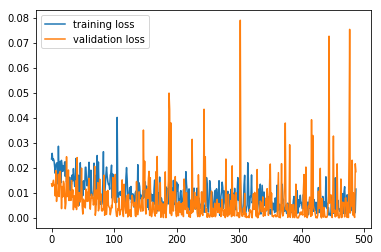

In [12]:
x = [i for i in range(len(validation_loss))]
plt.plot(x, training_loss)
plt.plot(x, validation_loss)
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

## 10 - Save checkpoint:
This section will save the trained the model so that we can use it later to make inference or if we decide to tune the hyper-parameters even more and retrain it again.

In [13]:
model.name = "modelSqueeze1_1"
checkpoint = {'model_name': model.name,
              'state_dict': model.state_dict()}
model.cpu
torch.save(checkpoint, 'checkpoint1.pth')

## 11 - Test using a separate test set :
It's mendatory to test the model on whole unseen sub set of the data to judge its performance .

In [14]:
def get_overall_accuracy(testloader):    
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
    
get_overall_accuracy(dataloaders['testLoader'])

Accuracy of the network on the test images: 91 %
